In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier  # MLP is an NN
from sklearn import svm
import numpy as np
import argparse
import imutils  # If you are unable to install this library, ask the TA; we only need this in extract_hsv_histogram.
import cv2  # cv2 
import os
import random
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score




#ddfda 


Preprocess the image 

1- aplly gaussian blur to remove noise


2- apply median blur to remove salt and pepper noise


3- resize image


4- mormalize pixels values

In [62]:
def preprocess_image(image_path, target_size=(64, 64)):
    """
    Preprocess the image by resizing, grayscaling, applying noise reduction, and normalizing.
    Args:
        image_path: Path to the image.
        target_size: Target size for resizing.
    Returns:
        Preprocessed image.
    """
    import cv2
    
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply a Median filter for further noise reduction (optional)
    filtered = cv2.medianBlur(blurred, 3)
    
    # Resize to the target size
    resized = cv2.resize(filtered, target_size)
    
    # Normalize pixel values to [0, 1]
    normalized = resized / 255.0
    
    return normalized


Extract HOG features 


def extract_hog_features(...): This function is defined to compute Histogram of Oriented Gradients (HOG) features from a given grayscale image. HOG features describe the distribution of gradient orientations in an image, useful for object detection and recognition.


image: Input parameter for the preprocessed image, expected to be in grayscale format.


orientations: Number of orientation bins used to compute the gradient histogram. Default is 9, meaning the gradient direction is divided into 9 bins (e.g., 0°–20°, 20°–40°, etc.).


pixels_per_cell: Defines the size of each cell in pixels. The gradient histogram is computed for each cell. Default size is 8x8 pixels.


cells_per_block: Specifies how many cells are grouped into a block for normalization. Default is a 2x2 block of cells.


In [63]:

def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    Extract HOG features from the image.
    Args:
        image: Preprocessed image (grayscale).
        orientations: Number of orientation bins.
        pixels_per_cell: Size of the cell in pixels.
        cells_per_block: Number of cells in each block.
    Returns:
        HOG feature vector.
    """


    hog_features = hog(image, orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys', visualize=False)
    '''
hog(image, ...): This function, imported from skimage.feature, computes the HOG features for the input image based on the specified parameters.

orientations=orientations: Specifies the number of bins for the gradient histogram.

pixels_per_cell=pixels_per_cell: Defines the dimensions of the cells for which the gradient histogram is computed.

cells_per_block=cells_per_block: Specifies the size of the block used for local contrast normalization.

block_norm='L2-Hys': Indicates the normalization method to use for the blocks. L2-Hys is a widely used normalization technique that improves robustness to lighting and contrast changes.

visualize=False: Disables the visualization of the HOG image, which is useful for debugging but not required for feature extraction.
'''
    return hog_features


Build list of features and labels for training the model 

In [64]:

def load_dataset(dataset_path, target_size=(64, 64)):
    """
    Load images, preprocess, and extract HOG features.
    Args:
        dataset_path: Root directory of the dataset.
        target_size: Target size for resizing.
    Returns:
        Features, labels, and class mapping.
    """
    features = []
    labels = []
    class_mapping = {}

    # Generate class mapping dynamically
    class_names = sorted(os.listdir(dataset_path))  # Sort for consistent label assignment
    for idx, class_name in enumerate(class_names):
        class_mapping[class_name] = idx  # Assign an index to each class

    for class_name, label in class_mapping.items():
        class_path = os.path.join(dataset_path, class_name)
        for file_name in os.listdir(class_path):
            image_path = os.path.join(class_path, file_name)
            # Preprocess the image
            preprocessed_image = preprocess_image(image_path, target_size)
            # Extract HOG features
            feature_vector = extract_hog_features(preprocessed_image)
            features.append(feature_vector)
            labels.append(label)

    return np.array(features), np.array(labels), class_mapping

# Define dataset path
dataset_path = r"F:\Universty\4th year\image\Project\Traffic_sign_recognition\dataset"

# Load dataset
X, y, class_mapping = load_dataset(dataset_path)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the class mapping
print("Class Mapping:", class_mapping)


Class Mapping: {'No Parking': 0, 'left': 1, 'return': 2, 'right': 3, 'speed_100': 4, 'speed_120': 5, 'speed_15': 6, 'speed_20': 7, 'speed_30': 8, 'speed_40': 9, 'speed_5': 10, 'speed_50': 11, 'speed_60': 12, 'speed_70': 13, 'speed_80': 14, 'stop': 15}


1- Train the model

2- Test the model

3- Evaluate the model

In [65]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate the SVM
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")


SVM Accuracy: 94.72%


Test the model on test images

In [66]:
def predict_image(image_path, model, class_mapping, target_size=(64, 64)):
    """
    Predict the class of a new image.
    Args:
        image_path: Path to the image.
        model: Trained SVM model.
        class_mapping: Mapping of class names to labels.
        target_size: Target size for resizing.
    Returns:
        Predicted class name.
    """
    # Preprocess and extract features
    preprocessed_image = preprocess_image(image_path, target_size)
    feature_vector = extract_hog_features(preprocessed_image).reshape(1, -1)
    # Predict
    prediction = model.predict(feature_vector)[0]
    # Map label back to class name
    for class_name, label in class_mapping.items():
        if label == prediction:
            return class_name




Draw bounding boxes around detected signs

In [67]:


def detect_and_draw_rectangles_around_signs(image_path, output_path=None):
    # Load the image
    predicted_class = predict_image(image_path, svm_model, class_mapping)
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Find contours in the edges image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Approximate the contour to a polygon
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Get bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(approx)
    
    # Draw the rectangle around the detected sign
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Save the result if an output path is provided
    if output_path:
        cv2.imwrite(output_path, image)
    
    # Display the image using matplotlib
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Predicted Traffic Sign: {predicted_class}")
    plt.axis('off')  # Hide axes
    plt.show()
    
    # Return the processed image
    return image



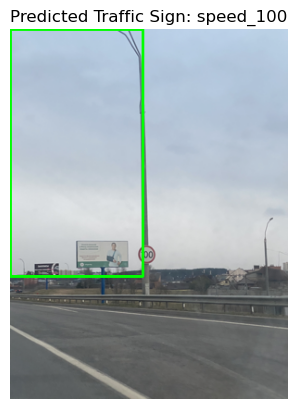

In [72]:
image_path = r"F:\Universty\4th year\image\Project\Traffic_sign_recognition\images\road250.png"
result_image = detect_and_draw_rectangles_around_signs(image_path)

In [80]:
import cv2
import numpy as np

def detect_shape(img):
    if img is None:
        raise ValueError("Image not loaded correctly")
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Perform edge detection
    edged = cv2.Canny(blurred, 50, 150)
    # Find contours in the edged image
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    shape = "unidentified"
    
    for contour in contours:
        # Compute the perimeter of the contour
        peri = cv2.arcLength(contour, True)
        # Approximate the contour
        approx = cv2.approxPolyDP(contour, 0.04 * peri, True)
        
        # If the shape has 3 vertices, it is a triangle
        if len(approx) == 3:
            shape = "triangle"
        # If the shape has 4 vertices, it is either a square, rectangle, or rhombus
        elif len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)
            
            # Calculate the side lengths of the quadrilateral
            sides = []
            for i in range(4):
                p1 = approx[i][0]
                p2 = approx[(i + 1) % 4][0]
                sides.append(np.linalg.norm(p1 - p2))
            
            # Check if all sides are nearly equal (characteristic of rhombus or square)
            if all(abs(sides[i] - sides[(i + 1) % 4]) < 5 for i in range(4)):
                # Check angles to distinguish between square and rhombus
                angles = []
                for i in range(4):
                    p1 = approx[i][0]
                    p2 = approx[(i + 1) % 4][0]
                    p3 = approx[(i + 2) % 4][0]
                    v1 = p1 - p2
                    v2 = p3 - p2
                    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
                    angles.append(np.degrees(angle))
                
                print(angles)
                # Check if angles are approximately 90 degrees
                if all(70 <= angle <= 110 for angle in angles):
                    shape = "square"
                else:
                    shape = "rhombus"
            else:
                shape = "rectangle"
        # If the shape has more than 4 vertices, it is a circle
        elif len(approx) > 4:
            shape = "circle"
    
    return shape


In [79]:
def detect_color(img):
    if img is None:
        raise ValueError("Image not loaded correctly")
    
    # Convert the image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define color ranges in HSV
    color_ranges = {
        "red": [(0, 70, 50), (10, 255, 255), (170, 70, 50), (180, 255, 255)],
        "green": [(36, 50, 70), (89, 255, 255)],
        "blue": [(90, 50, 70), (128, 255, 255)]
    }
    
    color_detected = "unidentified"
    
    for color, ranges in color_ranges.items():
        if color == "red":
            mask1 = cv2.inRange(hsv, np.array(ranges[0]), np.array(ranges[1]))
            mask2 = cv2.inRange(hsv, np.array(ranges[2]), np.array(ranges[3]))
            mask = cv2.bitwise_or(mask1, mask2)
        else:
            mask = cv2.inRange(hsv, np.array(ranges[0]), np.array(ranges[1]))
        
        # Check if any pixel in the mask is non-zero
        if cv2.countNonZero(mask) > 0:
            color_detected = color
            break
    
    return color_detected


Loading image from: F:\Universty\4th year\image\Project\Traffic_sign_recognition\images\road306.png
[135.0, 0.0, 90.0, 45.00000000000001]
[135.0, 8.537736462515939e-07, 153.434948822922, 18.434948822922017]
[135.0, 0.0, 135.0, 0.0]
[135.0, 0.0, 135.0, 1.2074182697257333e-06]
[135.0, 1.2074182697257333e-06, 135.0, 0.0]
[45.00000000000001, 135.0, 135.0, 45.00000000000001]
[135.0, 45.0, 135.0, 45.0]
[135.0, 135.0, 45.00000000000001, 45.00000000000001]
[30.34324888423957, 9.462322208025574, 41.63353933657021, 1.827968244304761]
[135.0, 135.0, 45.0, 45.0]
Shape: circle
Color: red


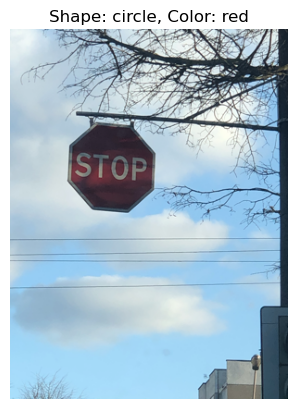

In [81]:
def test_shape_color_detection():
    # Use an absolute path to the image file
    img_path = r"F:\Universty\4th year\image\Project\Traffic_sign_recognition\images\road306.png"
    print(f"Loading image from: {img_path}")
    img = cv2.imread(img_path)

    if img is None:
        print("Error: Image not loaded correctly")
        return
    
    shape = detect_shape(img)
    color = detect_color(img)
    print("Shape:", shape)
    print("Color:", color)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Shape: {shape}, Color: {color}")
    plt.axis('off')  # Hide axes
    plt.show()

test_shape_color_detection()

In [ ]:



# def classify_traffic_sign(image_path):
#     # Read the image
#     img = cv2.imread(image_path)
    
#     # Detect shape and color
#     shape = detect_shape(img)
#     color = detect_color(img)
    
#     # Combine results
#     return f"Detected: {shape}, {color}"

# if _name_ == "_main_":
#     result = classify_traffic_sign("data/stop_sign.jpg")
#     print(result)

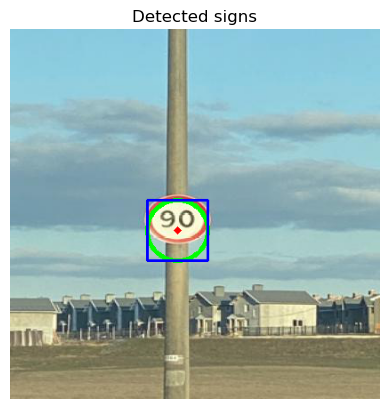

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# def detect_and_draw_rectangles2(image_path):
#     # Load the image
#     image = cv2.imread(image_path, cv2.IMREAD_COLOR)

#     # Convert to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Apply GaussianBlur to reduce noise and improve circle detection
#     blurred = cv2.GaussianBlur(gray, (15, 15), 0)

#     # Use HoughCircles to detect circles in the image
#     circles = cv2.HoughCircles(blurred, 
#                                 cv2.HOUGH_GRADIENT, dp=1.2, minDist=50,
#                                 param1=100, param2=30, minRadius=10, maxRadius=100)

#     # If circles are detected, draw rectangles around them
#     if circles is not None:
#         circles = np.round(circles[0, :]).astype("int")
#         for (x, y, r) in circles:
#             # Draw the circle center
#             cv2.circle(image, (x, y), 2, (0, 0, 255), 3)
#             # Draw the circle
#             cv2.circle(image, (x, y), r, (0, 255, 0), 4)
#             # Draw the rectangle (bounding box) around the circle
#             top_left = (x - r, y - r)
#             bottom_right = (x + r, y + r)
#             cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

#     # Display the result
#     img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     plt.imshow(img_rgb)
#     plt.axis('off')  # Hide axes
#     plt.title("Detected signs")
#     plt.show()





# # Example usage
# image_path = r"F:\Universty\4th year\image\Project\car\test\images\road811_png.rf.e8ae9aefbf35658164ee88a52ed39bd8.jpg"
# detect_and_draw_rectangles2(image_path)
